In [1]:
import os
from fs_solver import *
#from FsSolver import *

Libraries fetched!...



kwargs = {
    "dt": 0.1,
    "n_fs": 500,
    "max_iter": 2,
    "write": False,
    
    "PFS_kwargs": {
        "g_div": 20,
        "print_iter": True
    }
}

FsModel = FsSolver(airfoil = "0012", P = 1, alpha = 10, kwargs = kwargs)
FsModel.solve()

In [4]:

########### Trick: Kør først gang med max_iter_fs = 0, næste gang kører hurtigere ###########

kwargs = {"ylim":[-4,1], "xlim":[-13,13], "V_inf": 10, "g_div": 70, "write":True,
           "n_airfoil": 50,
           "n_fs": 100,
           "n_bed": 20,
           "n_inlet": 10,
           "n_outlet": 10,
           "rtol": 1e-8,
           "fs_rtol": 1e-2,
           "max_iter_fs": 10, 
           "dt": 1e-2,
           "a":1, "b":1}
FS = FsSolver("0012", alpha = 10, P=3, kwargs = kwargs)
#PFS = PotentialFlowSolver("0012", alpha = 10, P=4, kwargs=kwargs)

In [5]:
FS.solve()
#PFS.solve()

PoissonSolver stagnated in 6 iterations
	 Total time: 15.28735637664795
	 dGamma: 2.5249575142977696e-07
	 dot product: -6.173117945079687e-05


initialization done
	 Computing free surface equations
	 free surface equations done
PoissonSolver stagnated in 6 iterations
	 Total time: 13.15696120262146
	 dGamma: 3.697404694815452e-07
	 dot product: 5.422873524796312e-05


	 iteration: 1
	 residual norm 5.789273297218678e-05
	 iteration time: 14.276733875274658

	 Computing free surface equations


ConvergenceError: Nonlinear solve failed to converge after 14 nonlinear iterations.
Reason:
   DIVERGED_DTOL

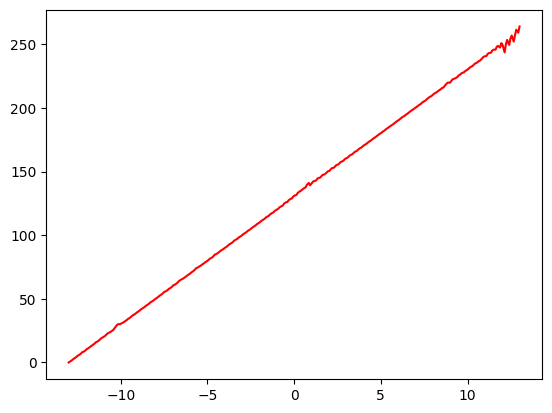

In [7]:
plt.plot(FS.fs_points[:, 0], FS.PhiTilde, 'r-', label='FS points')

In [ ]:
model = FS.model
# Mesh and function spaces
number_of_points = FS.fs_points.shape[0]
fs_mesh = fd.IntervalMesh(number_of_points-1, FS.xlim[0], FS.xlim[1])
V_eta = fd.FunctionSpace(fs_mesh, "CG", 1)
V_phi = fd.FunctionSpace(fs_mesh, "CG", 1)

# Defining unknown functions
W = V_eta * V_phi
eta_phi = fd.Function(W)
eta, phi = fd.split(eta_phi)
psi, zeta = fd.TestFunctions(W)

# Defining known functions
phi_n = fd.Function(V_phi)
eta_n = fd.Function(V_eta)
w_n = fd.Function(V_phi)
velocity = np.array(model.velocity.at(FS.fs_points))

phi_n.dat.data[:] = FS.PhiTilde
eta_n.dat.data[:] = FS.fs_points[:, 1]
w_n.dat.data[:] = velocity[:, 1]

g = fd.Constant(9.81)
dt = fd.Constant(0.01)

grad_eta = fd.grad(eta)
grad_phi = fd.grad(phi) + w_n * fd.grad(eta)

F1 = (fd.inner((eta - eta_n)/dt, psi) * fd.dx +
      fd.inner(fd.dot(grad_eta, grad_phi), psi) * fd.dx -
      fd.inner(w_n * (1 + fd.dot(grad_eta, grad_eta)), psi) * fd.dx
      )

F2 = (fd.inner((phi - phi_n)/dt, zeta) * fd.dx +
      fd.inner(g*eta, zeta)* fd.dx +
      fd.Constant(0.5) * 
      fd.inner(fd.dot(grad_phi, grad_phi) - 
               w_n**2 * (fd.Constant(1) + fd.dot(grad_eta, grad_eta)), zeta) * fd.dx
      )

F = F1 + F2

solver_params = {"newton_solver": {"relative_tolerance": 1e-6,}}
fd.solve(F == 0, eta_phi, solver_parameters=solver_params)

eta_n.assign(eta_phi.sub(0))
phi_n.assign(eta_phi.sub(1))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f270e286ff0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 206)), 329)

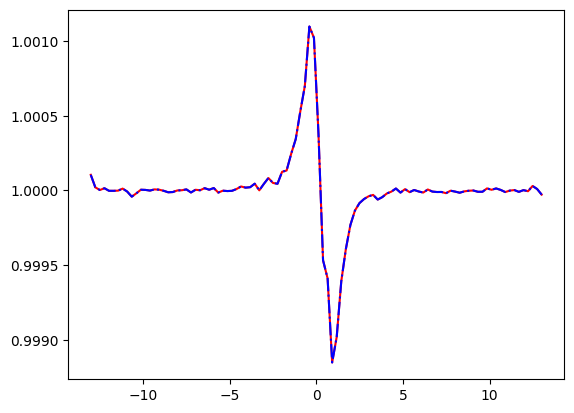

In [39]:
plt.plot(FS.fs_points[:, 0], eta_phi.sub(0).dat.data[:], 'r-', label='eta_n')
plt.plot(FS.fs_points[:, 0], eta_n.dat.data[:], 'b-.', label='eta_n')